This notebook was written by Shailesh Sridhar and Midhush. It was originally run on Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd
%ls

drive/  sample_data/


In [ ]:
%cp /content/drive/MyDrive/Canopy/project-canopy_data_RGB.zip /content/

In [ ]:
%pwd

'/content'

In [ ]:
!unzip project-canopy_data_RGB.zip

Streaming output truncated to the last 5000 lines.
 extracting: project-canopy_data_RGB/Roads/19_3400_3400.png  
 extracting: project-canopy_data_RGB/Roads/19_3500_3400.png  
 extracting: project-canopy_data_RGB/Roads/19_400_1500.png  
  inflating: project-canopy_data_RGB/Roads/19_400_1700.png  
  inflating: project-canopy_data_RGB/Roads/19_500_1400.png  
 extracting: project-canopy_data_RGB/Roads/19_500_1500.png  
 extracting: project-canopy_data_RGB/Roads/19_500_1700.png  
 extracting: project-canopy_data_RGB/Roads/19_600_1300.png  
 extracting: project-canopy_data_RGB/Roads/19_600_1400.png  
 extracting: project-canopy_data_RGB/Roads/19_600_1500.png  
 extracting: project-canopy_data_RGB/Roads/19_600_1600.png  
 extracting: project-canopy_data_RGB/Roads/19_600_1700.png  
 extracting: project-canopy_data_RGB/Roads/19_700_1100.png  
 extracting: project-canopy_data_RGB/Roads/19_700_1200.png  
 extracting: project-canopy_data_RGB/Roads/19_700_1300.png  
 extracting: project-canopy_data

In [ ]:
# import the necessary packages
import tensorflow.keras as keras
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import AveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Input
from keras.layers import add
from keras.models import Model
from keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50

# from tensorflow.python.keras.models import Model
# from tensorflow.python.keras.layers import Flatten, Dense, Dropout
# from tensorflow.python.keras.applications import ResNet50
# from tensorflow.python.keras.models import Sequential

class CanopyNet:
	@staticmethod
	def build(width, height, depth, classes):

		# net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
		# 			   input_shape=(width, height, depth))
		# res = net.output
		# res = GlobalAveragePooling2D()(res)
		# fc = Dense(classes, activation='softmax', name='fc1000')(res)
		# model = Model(inputs=net.input, outputs=fc)


		net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
					   input_shape=(width, height, depth))
		res = net.output
		res = Flatten()(res)
		res = Dropout(0.5)(res)
		fc = Dense(classes, activation='softmax', name='fc2')(res)
		model = Model(inputs=net.input, outputs=fc)

		# model = Sequential()
		# model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(width, height, depth)))
		# model.add(Flatten())
		# # model.add(BatchNormalization())
		# model.add(Dense(classes, activation='softmax', name='fc2'))

		# return the constructed network architecture

		return model

In [ ]:
import pdb
from collections import defaultdict
def load_and_process_csv(csv_path,train=True):
  df = pd.read_csv(csv_path)
  df = df.drop_duplicates()
  df = df[df[['0','1','2','3','4']].sum(axis=1) < 2] #Remove all rows with multiple labels
  if train:
    df['label'] = [i.split('/')[0] for i in df['paths']]
  else:
    df['label'] = [i.split('/')[3] for i in df['paths']]
  df = df[['paths','label']]

  df = df.sample(frac=1) #Shuffle rows
  return df

def convert_path(orig_path,path_type):
  if path_type == "train" :
    return '/'.join(['./project-canopy_data_RGB/',orig_path.split('/')[0],orig_path.split('/')[-1]]).replace('.tif','.png')

  if path_type == "test":
    return '/'.join(['./project-canopy_data_RGB/',orig_path.split('/')[3],orig_path.split('/')[-1]]).replace('.tif','.png')

#TODO: Check if this method of assigning labels is correct (VVIMP!!)
def df_to_data(df,df_type,balance_count=None):
  images = []
  labels = []
  label_counts = defaultdict(int)
  num_classes = len(set(df['label']))

  if balance_count is None:
     balance_count = len(df)
  
  for index,row in df.iterrows():
    label = row['label']
    if label_counts[label] >= balance_count:
      continue
    else:
      label_counts[label] += 1
    labels.append(label)
    path = row['paths']
    # if 'chips' 
    path = convert_path(path,df_type)
    img = cv2.imread(path)
    # pdb.set_trace()
    images.append(img)
    if len(labels) >= balance_count*num_classes: #Stop once we collect n =balance_count labels from each class
      break
  images = np.array(images, dtype="float") / 255.0
  return images,labels

def convert_labels(train_labels,test_labels):
  # pdb.set_trace()
  le = LabelEncoder()
  num_classes = len(set(train_labels))
  train_labels = le.fit_transform(train_labels)
  test_labels = le.transform(test_labels)
  trainY = np_utils.to_categorical(train_labels, num_classes)
  testY = np_utils.to_categorical(test_labels, num_classes)
  return trainY,testY,le

def get_labels_count(label_list):
  d = defaultdict(int)
  for label in label_list:
    d[label] += 1
  return d


def remove_class_imbalance(df,count_limit = None):
  l = []
  d = get_labels_count(df['label'])
  if count_limit == None:
    count_limit = min(d.values())

  curr_count = defaultdict(int)
  for index,row in df.iterrows():
    if curr_count[row['label']] >= count_limit:
      continue
    else:
      l.append(row)
      curr_count[row['label']] += 1
  return pd.DataFrame(l,columns = df.columns)


def get_class_weights_from_count(count_dict,le):
  class_weights = {}
  classes = le.classes_
  for i in range(len(classes)):
    class_weights[i] = count_dict[classes[i]]
  
  return class_weights







In [ ]:
import matplotlib
matplotlib.use("Agg")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
import pandas as pd

train_csv_path = "/content/drive/MyDrive/Canopy/new_train_labels_v8_half_nonisl_full.csv"
test_csv_path = "/content/drive/MyDrive/Canopy/new_test_labels_v3_one_third.csv"

train_df = load_and_process_csv(train_csv_path)[:]
# train_df = remove_class_imbalance(train_df,400)
test_df = load_and_process_csv(test_csv_path,train=False)[:]

trainX,train_labels = df_to_data(train_df,"train",1000)
testX,test_labels = df_to_data(test_df,"test")

trainY,testY,le = convert_labels(train_labels,test_labels)

# from sklearn.utils import class_weight
# class_weights = dict(zip(np.unique(trainY), 
#                          										class_weight.compute_class_weight(class_weight = 'balanced', 
# 												                                               classes = np.unique(trainY), 
#                 																												y= trainY))) 

class_weights = get_class_weights_from_count(get_labels_count(train_labels),le)
pdb.set_trace()
#TODO: Add code to save data to pickle and save model checkpoints



# # partition the data into training and testing splits using 75% of
# # the data for training and the remaining 25% for testing
# (trainX, testX, trainY, testY) = train_test_split(data, labels,
# 	test_size=0.25, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")



# for imagePath in imagePaths:
# 	# extract the class label from the filename, load the image and
# 	# resize it to be a fixed 32x32 pixels, ignoring aspect ratio
# 	label = imagePath.split(os.path.sep)[-2]
# 	image = cv2.imread(imagePath)
# 	#print(imagePath)
# 	image = cv2.resize(image, (32, 32))

# 	# update the data and labels lists, respectively
# 	data.append(image)
# 	labels.append(label)




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 332, in set_trace
    sys.settrace(self.trace_dispatch)



--Return--
> <ipython-input-5-3ffbdd673e2f>(37)<module>()->None
-> pdb.set_trace()
(Pdb) c



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 343, in set_continue
    sys.settrace(None)



In [ ]:
# trainX,train_labels = df_to_data(train_df)
# !ls project-canopy_data_RGB/misc 
# os.path.exists('./project-canopy_data_RGB/misc/12_2200_4700.png')
# !ls

# set(test_df['label'])
# trainX.shape
# test_df['paths']
# convert_path(test_df['paths'].iloc[0],path_type="test")
# get_labels_count(train_df['label'])
# train_df_2 = remove_class_imbalance(train_df,400)
print(get_labels_count(train_df['label']))
# train_df_2
# len(trainY)
print(len(train_df))

defaultdict(<class 'int'>, {'misc': 72260, 'Industrial_agriculture': 814, 'ISL': 3454, 'Shifting_cultivation': 2048, 'Roads': 548, 'Mining': 117})
79241


In [ ]:
INIT_LR = 1e-4
BS = 8
EPOCHS = 10

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = CanopyNet.build(width=100, height=100, depth=3,
	classes=len(le.classes_))
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network for {} epochs...".format(EPOCHS))

##WITH CLASS WEIGHTS
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,class_weight = class_weights)
'''
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS)
'''
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


94781440/94765736 [==============================] - 1s 0us/step
[INFO] training network for 10 epochs...


ValueError: ignored

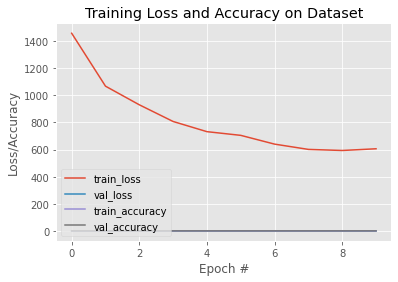

In [ ]:
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(args["plot"])